In my code, I've implemented a versatile text analysis framework incorporating advanced techniques such as Latent Dirichlet Allocation (LDA), K-means clustering, and Sentence-Level Transformer Embeddings. Leveraging the power of transformer models, like BERT or GPT, at the sentence level allows for a more nuanced understanding of the contextual relationships within the entire text. This hybrid approach enables the extraction of latent topics through LDA, clustering of similar documents using K-means, and the integration of rich semantic representations from transformer embeddings, collectively offering a comprehensive analysis of the textual data.

In [2]:
# Import necessary libraries
import pandas as pd
import json
import gzip
from datetime import datetime
import random
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import re
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
import os
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Set the current working directory to the directory of the notebook

In [3]:
notebook_directory = os.getcwd()
os.chdir(notebook_directory)

Following code is a data loading and exploration step, aiming to read a random subset of arXiv abstracts from a JSON Lines file, convert it into a Pandas DataFrame, and display the initial rows for a quick examination of the dataset. Adjustments can be made to the sample_size variable based on the desired subset size.

In [4]:
# Specify the path to your JSON Lines file
file_path = 'Data/arxiv-abstracts.jsonl.gz'

# Set a fixed seed for reproducibility
random.seed(42)

# Open the gzipped JSON Lines file
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    # Read a random subset of lines (adjust the sample_size as needed)
    sample_size = 1000000
    data = [json.loads(line) for line in random.sample(file.readlines(), sample_size)]

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())

           id         submitter  \
0  2008.13253      Edgar Galvan   
1   1012.4110       Eoin Butler   
2   0803.0691  Paul E. Gunnells   
3  2111.01041          Tong Liu   
4   1411.6806     Huy Pham Cong   

                                             authors  \
0  Edgar Galv\'an, Oxana Gorshkova, Peter Mooney,...   
1  Gorm B. Andresen, Mohammad D. Ashkezari, Marce...   
2                 Gautam Chinta and Paul E. Gunnells   
3                 Shuang-Xi Yi, Mei Du, and Tong Liu   
4                     C. Huy Pham and V. Lien Nguyen   

                                               title  \
0  Statistical Tree-based Population Seeding for ...   
1                    Search For Trapped Antihydrogen   
2  Constructing Weyl group multiple Dirichlet series   
3  Statistical analyses on the energies of X-ray ...   
4  Tunnelling through finite graphene superlattic...   

                                            comments  \
0                                 14 Pages, 5 Tables   
1  

Following code chunk extracts publication dates from arXiv IDs by creating a 'publication_date' column in the DataFrame (df). The dates are derived from the year and month portions of the IDs. The resulting DataFrame includes the new temporal information.

In [5]:
# Extract publication dates from arXiv IDs and create a new 'publication_date' column
def extract_date(x):
    year_month = re.search(r'(\d{2})(\d{2})', x)
    if year_month:
        year, month = year_month.groups()
        return datetime.strptime(f"{year}-{month}-01", "%y-%m-%d")
    else:
        return None

df['publication_date'] = df['id'].apply(extract_date)

# Display the first few rows of the DataFrame with the new 'publication_date' column
df

,id,submitter,authors,title,comments,journal-ref,doi,abstract,report-no,categories,versions,publication_date
0,2008.13253,Edgar Galvan,"Edgar Galv\'an, Oxana Gorshkova, Peter Mooney,...",Statistical Tree-based Population Seeding for ...,"14 Pages, 5 Tables",None,None,Multiple Artificial Intelligence (AI) method...,None,[cs.NE],[v1],2020-08-01
1,1012.4110,Eoin Butler,"Gorm B. Andresen, Mohammad D. Ashkezari, Marce...",Search For Trapped Antihydrogen,"12 pages, 7 figures",Physics Letters B 695 (2011) 95-104,10.1016/j.physletb.2010.11.004,We present the results of an experiment to s...,None,[physics.atom-ph hep-ex],[v1],2010-12-01
2,0803.0691,Paul E. Gunnells,Gautam Chinta and Paul E. Gunnells,Constructing Weyl group multiple Dirichlet series,incorporates referee's revisions,None,None,Let Phi be a reduced root system of rank r. ...,None,[math.NT math.RT],"[v1, v2]",2008-03-01
3,2111.01041,Tong Liu,"Shuang-Xi Yi, Mei Du, and Tong Liu",Statistical analyses on the energies of X-ray ...,"13 pages, 3 figures, 3 tables, accepted for pu...",None,None,Distinct X-ray plateau and flare phases have...,None,[astro-ph.HE],[v1],2021-11-01
4,1411.6806,Huy Pham Cong,C. Huy Pham and V. Lien Nguyen,Tunnelling through finite graphene superlattic...,"21 pages, 6 figures",J. Phys.: Condens. Matter 27 (2015) 095302,10.1088/0953-8984/27/9/095302,An exact expression of the transmission prob...,None,[cond-mat.mes-hall],"[v1, v2]",2014-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1805.08502,Jenny Poulton,"Jenny Poulton, Pieter Rein ten Wolde, Thomas E...",Non-equilibrium correlations in minimal dynami...,None,None,None,"Living systems produce ""persistent"" copies o...",None,[cond-mat.stat-mech],"[v1, v2]",2018-05-01
999996,1712.02941,Ken Sakurada,"Ken Sakurada, Weimin Wang, Nobuo Kawaguchi, Ry...",Dense Optical Flow based Change Detection Netw...,None,None,None,This paper presents a novel method for detec...,None,[cs.CV],[v1],2017-12-01
999997,hep-ph/0301034,Jisuke Kubo,Jisuke Kubo (UNAM and Kanazawa U),Renormalization Group Approach to the SUSY Fla...,"9 pages, LaTeX",AIP Conf.Proc. 670 (2003) 315-322,10.1063/1.1594349,Renormalization group approach to the SUSY f...,"IFUNAM-FT2003-01, KANAZAWA-03-01",[hep-ph],[v1],2003-01-01
999998,1310.3396,Raphael Hauser A,Thomas Schmelzer and Raphael Hauser,Seven Sins in Portfolio Optimization,None,None,None,Although modern portfolio theory has been in...,None,[q-fin.PM],[v1],2013-10-01


Following chunk performs the following tasks:

1. Converts the text in the 'abstract' column of the DataFrame (df) to lowercase.
2. Defines a list of NLP-related keywords.
3. Creates a boolean mask, nlp_mask, indicating whether each abstract contains any of the specified NLP-related keywords.
4. Applies the mask to filter the DataFrame, creating a new DataFrame (nlp_papers_df) containing only papers related to Natural Language Processing (NLP).
5. Displays the initial rows of the DataFrame containing NLP-related papers.

In [6]:
# Convert abstracts to lowercase
df['abstract'] = df['abstract'].str.lower()

# Filter papers related to NLP using keyword matching
nlp_word = ['nlp']

# Create a boolean mask indicating whether each abstract contains NLP-related keywords
nlp_mask_one = df['abstract'].apply(lambda x: any(keyword in x.lower() for keyword in nlp_word))

# Filter the DataFrame using the boolean mask
nlp_paper = df[nlp_mask_one]

# Display the filtered DataFrame
nlp_paper

,id,submitter,authors,title,comments,journal-ref,doi,abstract,report-no,categories,versions,publication_date
11,2110.15149,Wenjuan Han,"Wenjuan Han, Hwee Tou Ng",Diversity-Driven Combination for Grammatical E...,Accepted by ICTAI 2021,None,None,grammatical error correction (gec) is the ta...,None,[cs.CL],[v1],2021-10-01
836,1803.07136,Rick Dale,"Rick Dale, Nicholas D. Duran, and Moreno Coco",Dynamic Natural Language Processing with Recur...,None,None,None,writing and reading are dynamic processes. a...,None,[cs.CL],[v1],2018-03-01
1094,2110.00737,Ashad Kabir,"A.R. Sana Ullah, Anupam Das, Anik Das, Muhamma...","A Survey of COVID-19 Misinformation: Datasets,...","43 pages, 6 figures",None,None,misinformation during pandemic situations li...,None,[cs.SI],"[v1, v2]",2021-10-01
1838,2101.11492,Laura P\'erez-Mayos,"Laura P\'erez-Mayos, Roberto Carlini, Miguel B...",On the Evolution of Syntactic Information Enco...,None,None,None,the adaptation of pretrained language models...,None,[cs.CL],"[v1, v2]",2021-01-01
2255,1606.04835,Qi Li,"Qi Li, Tianshi Li, Baobao Chang",Learning Word Sense Embeddings from Word Sense...,To appear at NLPCC-ICCPOL 2016,None,None,word embeddings play a significant role in m...,None,[cs.CL],"[v1, v2, v3, v4]",2016-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...
999038,2105.08882,Enrico Santus,"Beatrice Portelli, Daniele Passab\`i, Edoardo ...",Improving Adverse Drug Event Extraction with S...,"11 pages, AAAI, conference",None,None,"in recent years, internet users are reportin...",None,[cs.CL cs.LG],[v1],2021-05-01
999110,1812.10408,Hugo Chu,Marko Valentin Micic and Hugo Chu,Hyperbolic Deep Learning for Chinese Natural L...,"11 pages, 1 figure",None,None,recently hyperbolic geometry has proven to b...,None,[cs.CL cs.LG],[v1],2018-12-01
999339,1904.04866,Denis Newman-Griffis,"Brendan Whitaker, Denis Newman-Griffis, Aparaj...",Characterizing the impact of geometric propert...,Appearing in the Third Workshop on Evaluating ...,None,None,analysis of word embedding properties to inf...,None,[cs.CL cs.LG],[v1],2019-04-01
999747,1903.01411,Mihael Arcan,Mihael Arcan and John McCrae and Paul Buitelaar,Polylingual Wordnet,None,None,None,princeton wordnet is one of the most importa...,None,[cs.CL],[v1],2019-03-01


This performs the same as before but with more NLP related key words, as I didn't think 2232 rows out of a million was enough.

In [9]:
# Filter papers related to NLP using keyword matching
nlp_keywords = ['natural language processing', 'nlp', 'text mining', 'language understanding', 'computational linguistics', 'speech recognition', 'named entity recognition', 'tokenization', 'topic modeling', 'chatgpt', 'gpt', 'language transformers']

# Create a boolean mask indicating whether each abstract contains NLP-related keywords
nlp_mask = df['abstract'].apply(lambda x: any(keyword in x.lower() for keyword in nlp_keywords))

# Apply the mask to filter the DataFrame
nlp_papers_df = df[nlp_mask]

# Display the first few rows of the DataFrame containing NLP papers
nlp_papers_df

,id,submitter,authors,title,comments,journal-ref,doi,abstract,report-no,categories,versions,publication_date
11,2110.15149,Wenjuan Han,"Wenjuan Han, Hwee Tou Ng",Diversity-Driven Combination for Grammatical E...,Accepted by ICTAI 2021,None,None,grammatical error correction (gec) is the ta...,None,[cs.CL],[v1],2021-10-01
108,2008.03923,Prakhar Swarup,"Prakhar Swarup, Debmalya Chakrabarty, Ashtosh ...",Knowledge Distillation and Data Selection for ...,None,None,None,semi-supervised learning (ssl) is an active ...,None,[cs.CL eess.AS],[v1],2020-08-01
709,2101.02667,Seyed Abolfazl Ghasemzadeh,"Seyed Abolfazl Ghasemzadeh, Erfan Bank Tavakol...",BRDS: An FPGA-based LSTM Accelerator with Row-...,"8 pages, 9 figures, 2 tables",None,None,"in this paper, first, a hardware-friendly pr...",None,[cs.AR cs.LG],[v1],2021-01-01
836,1803.07136,Rick Dale,"Rick Dale, Nicholas D. Duran, and Moreno Coco",Dynamic Natural Language Processing with Recur...,None,None,None,writing and reading are dynamic processes. a...,None,[cs.CL],[v1],2018-03-01
1018,1101.4479,Daoud Clarke,Daoud Clarke,A Context-theoretic Framework for Compositiona...,Submitted to Computational Linguistics on 20th...,None,None,techniques in which words are represented as...,None,[cs.CL cs.AI],[v1],2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
999194,1706.10268,Zahra Ghodsi,"Zahra Ghodsi, Tianyu Gu, Siddharth Garg",SafetyNets: Verifiable Execution of Deep Neura...,None,Advances in Neural Information Processing Syst...,None,inference using deep neural networks is ofte...,None,[cs.LG cs.CR],[v1],2017-06-01
999339,1904.04866,Denis Newman-Griffis,"Brendan Whitaker, Denis Newman-Griffis, Aparaj...",Characterizing the impact of geometric propert...,Appearing in the Third Workshop on Evaluating ...,None,None,analysis of word embedding properties to inf...,None,[cs.CL cs.LG],[v1],2019-04-01
999539,2009.02110,Jose A. Gonzalez-Lopez,"Jose A. Gonzalez-Lopez, Alejandro Gomez-Alanis...",Silent Speech Interfaces for Speech Restoratio...,None,None,10.1109/ACCESS.2020.3026579,this review summarises the status of silent ...,None,[eess.AS cs.HC cs.LG],"[v1, v2, v3]",2020-09-01
999747,1903.01411,Mihael Arcan,Mihael Arcan and John McCrae and Paul Buitelaar,Polylingual Wordnet,None,None,None,princeton wordnet is one of the most importa...,None,[cs.CL],[v1],2019-03-01


So, now I've got some more rows to work with. Some papers might be related to something else even though the keywords are related to NLP, but that's a choice I've taken to get a larger dataset.

In the following code I'll find the oldest NLP paper from my dataframe. I'll need this for later tasks.

In [10]:
# Sort the DataFrame by 'publication_date' in ascending order
oldest_paper = nlp_papers_df.sort_values(by='publication_date', ascending=True).iloc[0]

# Display the oldest paper
print(oldest_paper)

id                                                     cmp-lg/9405018
submitter                                                        None
authors                                              Walter Daelemans
title                 Memory-Based Lexical Acquisition and Processing
comments                                                     18 pages
journal-ref         Steffens (ed.) Machine Translation & Lexion. S...
doi                                                              None
abstract              current approaches to computational lexicolo...
report-no                                                        None
categories                                             [cmp-lg cs.CL]
versions                                                         [v1]
publication_date                                  1994-05-01 00:00:00
Name: 510213, dtype: object


In the following code, I'm initializing a WordNet lemmatizer, setting up stop words, and creating an empty list to store the cleaned abstracts. The subsequent loop iterates through the NLP-related abstracts, tokenizes and lemmatizes each abstract, removes stop words, and joins the filtered tokens to form the cleaned abstracts.

In [11]:
# Load lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

cleaned_abstracts = []
for abstract in nlp_papers_df['abstract']:
    # Tokenize and lemmatize
    tokens = word_tokenize(abstract)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]
    # Remove stop words
    filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]
    cleaned_abstracts.append(' '.join(filtered_tokens))

In the following code, I will perform LDA (Latent Dirichlet Allocation). At first, I'll create a bag of words (BoW):

In [12]:
# Create Bag of Words (BoW) representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_abstracts)

In this code, we perform dimensionality reduction on a term-document matrix (X). Our goal is to retain 90% of the most informative words based on their cumulative occurrences across all documents. The result is a reduced feature space (X_filtered) with a smaller set of columns.

In [13]:
# Dimensionality reduction
print(f'Shape before filtering: {X.shape}') # Original feature space with many columns

# We will only use 90% of the words
threshold = 0.90

# Calculate the sum of occurrences for each word across all documents
column_sums = X.sum(axis=0)

# Convert to a numpy array for easier manipulation
column_sums_array = column_sums.A1

# Sort indices in descending order based on column sums
sorted_indices = np.argsort(column_sums_array)[::-1]

# Calculate the cumulative sum of column sums
cumulative_sum = np.cumsum(column_sums_array[sorted_indices])

# Find the index where cumulative sum exceeds 'threshold' of total tokens
threshold_index = np.argmax(cumulative_sum >= threshold * cumulative_sum[-1])

# Select only the top elements up to the threshold index
selected_indices = sorted_indices[:threshold_index + 1]
X_filtered = X[:, selected_indices]

# Extract list of words in retained parts of X
feature_names = np.array(vectorizer.get_feature_names_out())
retained_tokens = feature_names[selected_indices].tolist()

print(f'Shape after filtering: {X_filtered.shape}') # Reduced feature space with fewer columns

Shape before filtering: (5840, 18610)
Shape after filtering: (5840, 2957)


So, after the filtering, the shape went from 18,610 columns to only 2,957.

In the following code, we determine the optimal number of topics for the LDA model using the Elbow Method. The perplexity metric is employed for evaluation. The code iterates over different numbers of topics, fits LDA models, collects evaluation metrics, and plots the results. The elbow point on the plot indicates the suggested optimal number of topics.

fitting num_topics = 3
fitting num_topics = 4
fitting num_topics = 5
fitting num_topics = 6
fitting num_topics = 7
fitting num_topics = 8
fitting num_topics = 9
fitting num_topics = 10
fitting num_topics = 11
fitting num_topics = 12
fitting num_topics = 13
fitting num_topics = 14
fitting num_topics = 15
fitting num_topics = 16
fitting num_topics = 17
fitting num_topics = 18
fitting num_topics = 19
fitting num_topics = 20


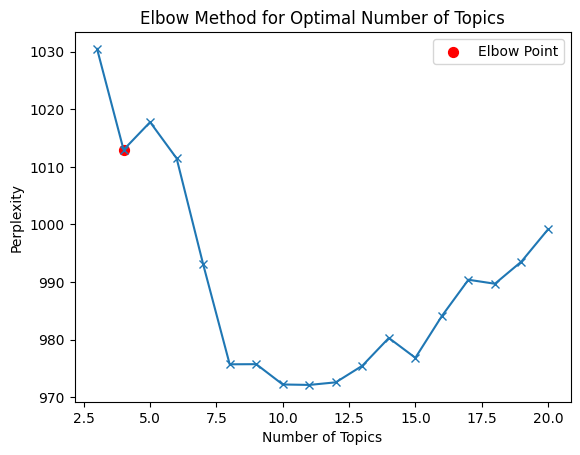

In [14]:
# Step 3: Determine the optimal number of topics using an elbow point
eval_metric_values = []
num_topics_range = range(3, 21)

for num_topics in num_topics_range:
    print(f'fitting num_topics = {num_topics}')
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X_filtered)

    # Evaluation metric
    perplexity = lda.perplexity(X_filtered)

    eval_metric_values.append(perplexity)

# Identify the elbow point
diffs = np.diff(eval_metric_values)
elbow_point = np.where(diffs > 0)[0][0] + 3  # Add 3 because we started from num_topics=3

# Plot the evaluation metric values against the number of topics
plt.plot(num_topics_range, eval_metric_values, marker='x')
plt.title('Elbow Method for Optimal Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')

# Mark the elbow point on the plot
plt.scatter(elbow_point, eval_metric_values[elbow_point - 3], c='red', label='Elbow Point', marker='o', s=50)
plt.legend()

plt.show()

In [15]:
# Print the identified optimal number of topics
print(f"Optimal Number of Topics (Elbow Point): {elbow_point}")

Optimal Number of Topics (Elbow Point): 4


As 4 is the optimal number of topics according to the elbow plot, I will refit the LDA model with that. After fitting, the code displays the top words for each topic based on the model's learned component distributions. The selected_indices are used to map back to the original feature space. The result provides insight into the dominant words associated with each identified topic. Some could argue that 8, 9 or 10 might be better based og the perplexity, but I think 4 might be a fitting number.

In [16]:
# Refit with optimal topics
elbow_point = 4
lda = LatentDirichletAllocation(n_components=elbow_point, random_state=42)
lda.fit(X_filtered)

# Look at the results
# Display the top words for each topic
feature_names = np.array(vectorizer.get_feature_names_out())[selected_indices]

print("Top words for each topic:")
for topic_id, topic in enumerate(lda.components_):
    top_word_indices = topic.argsort()[:-11:-1]  # Get the indices of the top 10 words
    top_words = feature_names[top_word_indices]
    print(f"Topic {topic_id + 1}: {', '.join(top_words)}\n{'-'*50}")

Top words for each topic:
Topic 1: model, language, word, task, representation, method, text, semantic, embeddings, natural
--------------------------------------------------
Topic 2: model, method, algorithm, problem, network, learning, data, training, processing, approach
--------------------------------------------------
Topic 3: speech, model, recognition, system, asr, network, training, data, neural, performance
--------------------------------------------------
Topic 4: language, model, data, task, text, nlp, learning, natural, research, processing
--------------------------------------------------


In this code chunk, I will calculate and display the top words and their frequencies for each topic generated by the LDA model. Using a Counter, I'll keep track of the total count of each word across topics. Additionally, the code will visualize the word frequencies for each topic and present the total word frequencies across all topics. The ultimate goal is to provide insights into the most representative words within each topic and their overall prevalence across the entire dataset.

Top words and their frequencies for each topic (cleaned_abstracts):
Topic 1 (cleaned_abstracts):
model: 4103
language: 3542
task: 2903
natural: 2461
text: 2343
method: 2338
word: 1454
representation: 1055
semantic: 815
embeddings: 513


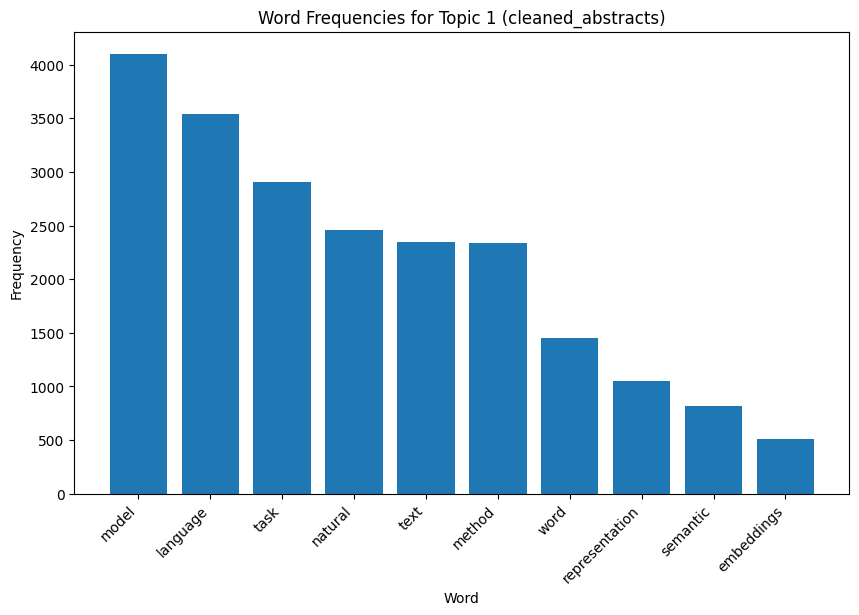

--------------------------------------------------
Topic 2 (cleaned_abstracts):
model: 4103
data: 3390
method: 2338
processing: 2141
learning: 1967
approach: 1954
training: 1651
network: 1546
problem: 1328
algorithm: 887


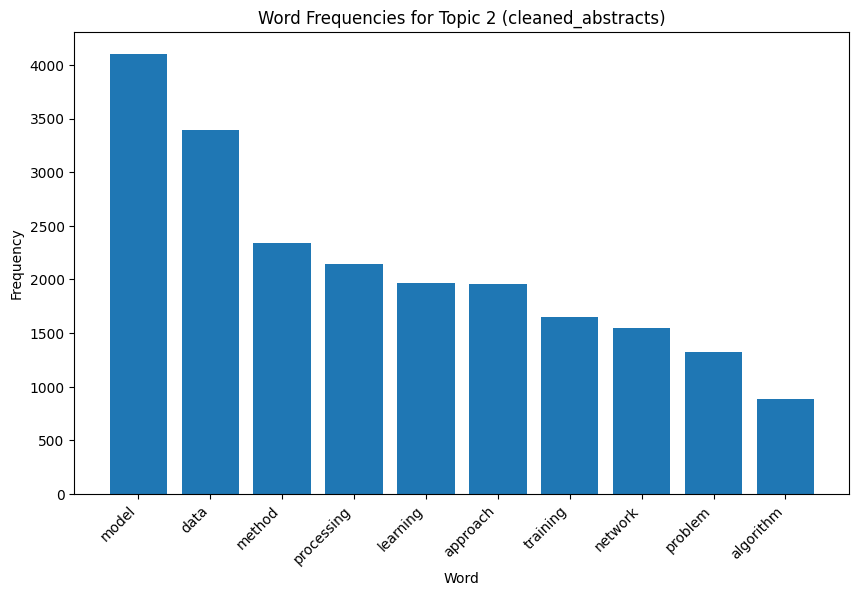

--------------------------------------------------
Topic 3 (cleaned_abstracts):
model: 4103
data: 3390
performance: 2167
system: 1913
recognition: 1720
training: 1651
network: 1546
neural: 1496
speech: 1405
asr: 483


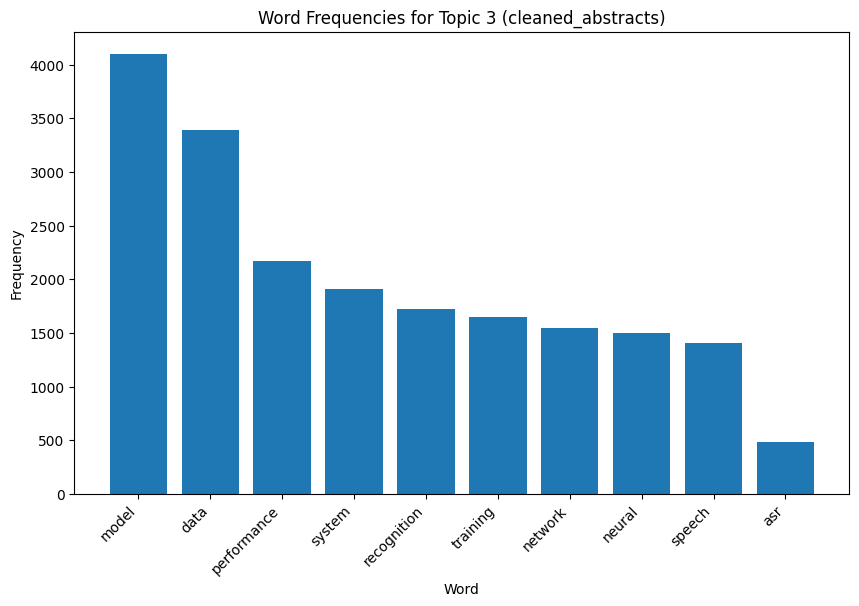

--------------------------------------------------
Topic 4 (cleaned_abstracts):
model: 4103
language: 3542
data: 3390
task: 2903
natural: 2461
text: 2343
processing: 2141
nlp: 2129
learning: 1967
research: 1200


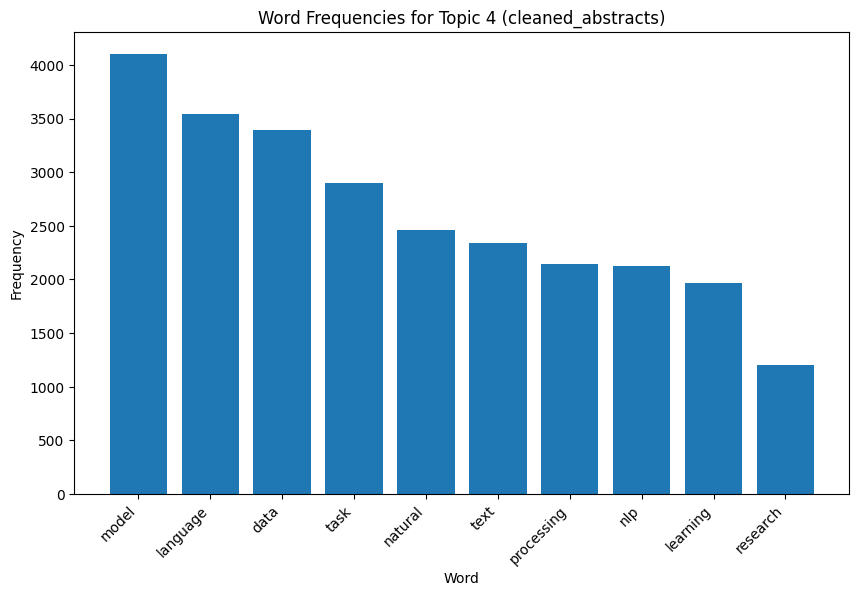

--------------------------------------------------
Total word counts across all topics (cleaned_abstracts):
model: 16412
data: 10170
language: 7084
task: 5806
natural: 4922
text: 4686
method: 4676
processing: 4282
learning: 3934
training: 3302
network: 3092
performance: 2167
nlp: 2129
approach: 1954
system: 1913
recognition: 1720
neural: 1496
word: 1454
speech: 1405
problem: 1328
research: 1200
representation: 1055
algorithm: 887
semantic: 815
embeddings: 513
asr: 483


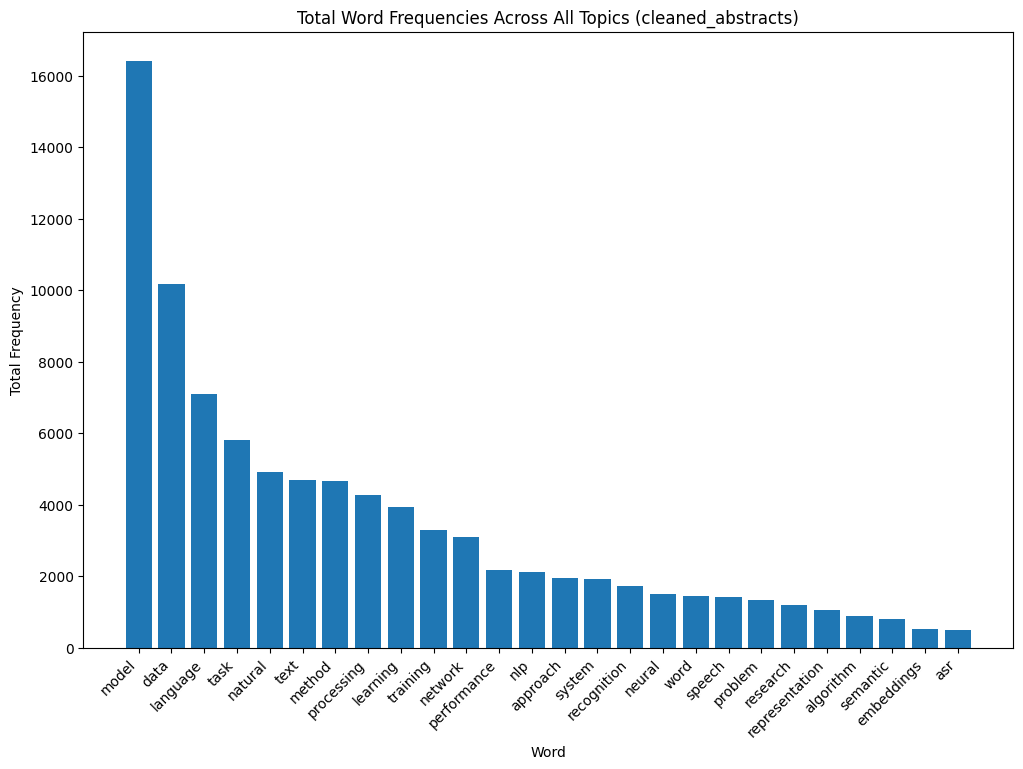

In [17]:
# Display the top words and their frequencies for each topic (cleaned_abstracts)
feature_names = np.array(vectorizer.get_feature_names_out())[selected_indices]

# Create a Counter to store the total count of each word
total_word_counts = Counter()

print("Top words and their frequencies for each topic (cleaned_abstracts):")
for topic_id, topic in enumerate(lda.components_):
    top_word_indices = topic.argsort()[:-11:-1]  # Get the indices of the top 10 words
    top_words = feature_names[top_word_indices]

    # Count the occurrences of each word in the entire set of abstracts
    word_counts = Counter()
    for abstract in cleaned_abstracts:
        for word in top_words:
            if word in abstract:
                word_counts[word] += 1

    # Update the total count of each word
    total_word_counts.update(word_counts)

    print(f"Topic {topic_id + 1} (cleaned_abstracts):")
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    for word, count in sorted_word_counts:
        print(f"{word}: {count}")

    # Visualize the word frequencies for the current topic
    sorted_word_counts_for_plot = sorted_word_counts[:10]  # Display only the top 10 words in the plot
    plt.figure(figsize=(10, 6))
    plt.bar([word[0] for word in sorted_word_counts_for_plot], [count[1] for count in sorted_word_counts_for_plot])
    plt.title(f"Word Frequencies for Topic {topic_id + 1} (cleaned_abstracts)")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    print('-' * 50)

# Display the total count of each word across all topics (cleaned_abstracts)
print("Total word counts across all topics (cleaned_abstracts):")
sorted_total_word_counts = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)
for word, count in sorted_total_word_counts:
    print(f"{word}: {count}")

# Visualize the total word frequencies across all topics (cleaned_abstracts)
plt.figure(figsize=(12, 8))
plt.bar([word[0] for word in sorted_total_word_counts], [count[1] for count in sorted_total_word_counts])
plt.title("Total Word Frequencies Across All Topics (cleaned_abstracts)")
plt.xlabel("Word")
plt.ylabel("Total Frequency")
plt.xticks(rotation=45, ha='right')
plt.show()


In this chunk, I'll create a copy of the NLP-related papers DataFrame to address potential warnings. Using LDA, I'll identify the dominant topic and its contribution for each document. New columns, 'dominant_topic' and 'topic_contribution', will be added to store this information. The resulting DataFrame will then be displayed, offering a concise overview of key details for each NLP-related paper.

In [18]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
nlp_papers_df = df[nlp_mask].copy()

# Get the topic distribution for each document
topic_distribution = lda.transform(X_filtered)

# Identify the dominant topic for each document
dominant_topic = np.argmax(topic_distribution, axis=1)

# Create new columns in the DataFrame for dominant topic and its percentage contribution
nlp_papers_df['dominant_topic'] = dominant_topic + 1
nlp_papers_df['topic_contribution'] = topic_distribution.max(axis=1)

# Display the DataFrame with the new columns
nlp_papers_df[['id', 'submitter', 'publication_date', 'abstract', 'dominant_topic', 'topic_contribution']].head(10)

,id,submitter,publication_date,abstract,dominant_topic,topic_contribution
11,2110.15149,Wenjuan Han,2021-10-01,grammatical error correction (gec) is the ta...,3,0.564116
108,2008.03923,Prakhar Swarup,2020-08-01,semi-supervised learning (ssl) is an active ...,3,0.650586
709,2101.02667,Seyed Abolfazl Ghasemzadeh,2021-01-01,"in this paper, first, a hardware-friendly pr...",2,0.748837
836,1803.07136,Rick Dale,2018-03-01,writing and reading are dynamic processes. a...,4,0.584875
1018,1101.4479,Daoud Clarke,2011-01-01,techniques in which words are represented as...,1,0.847415
1094,2110.00737,Ashad Kabir,2021-10-01,misinformation during pandemic situations li...,4,0.990793
1107,2109.10252,Surya Kant Sahu,2021-09-01,transformers have seen an unprecedented rise...,3,0.525497
1140,2002.12804,Li Dong,2020-02-01,we propose to pre-train a unified language m...,1,0.680109
1713,1612.03969,Mikael Henaff,2016-12-01,"we introduce a new model, the recurrent enti...",2,0.432035
1763,2009.13971,Xuemeng Hu,2020-09-01,advances on deep generative models have attr...,1,0.833906


In this code chunk, I'll count the occurrences of each dominant topic within the NLP-related papers DataFrame. The resulting counts are then visualized through a bar chart, providing a clear distribution of dominant topics. This visual representation allows for a quick understanding of the prevalence of different topics across the subset of NLP-related documents.

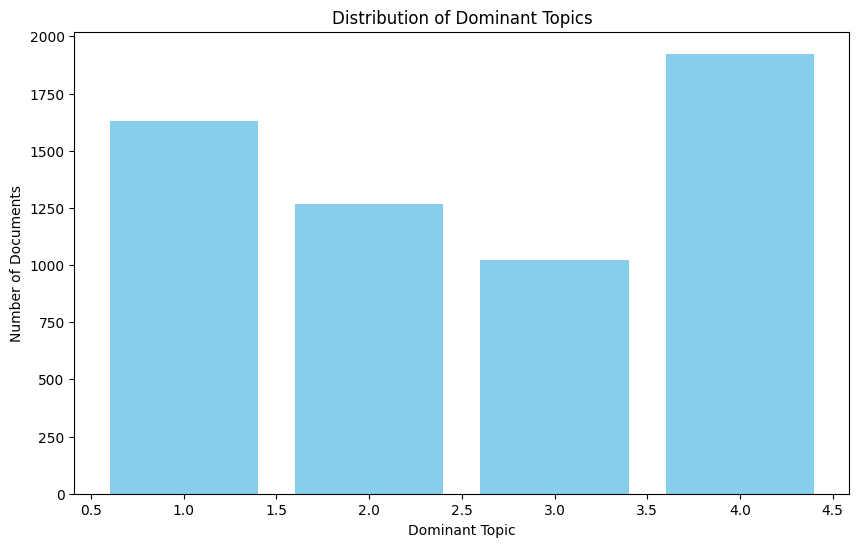

In [19]:
# Count the occurrences of each dominant topic
dominant_topic_counts = nlp_papers_df['dominant_topic'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(dominant_topic_counts.index, dominant_topic_counts.values, color='skyblue')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Documents')
plt.show()

The following code chunk visually represents the topic distribution of documents in a lower-dimensional space (2D) using t-SNE, aiming to reveal patterns or clusters among the documents based on their dominant topics. The color-coded points on the scatter plot provide insights into how documents with different dominant topics are positioned relative to each other in the reduced space.

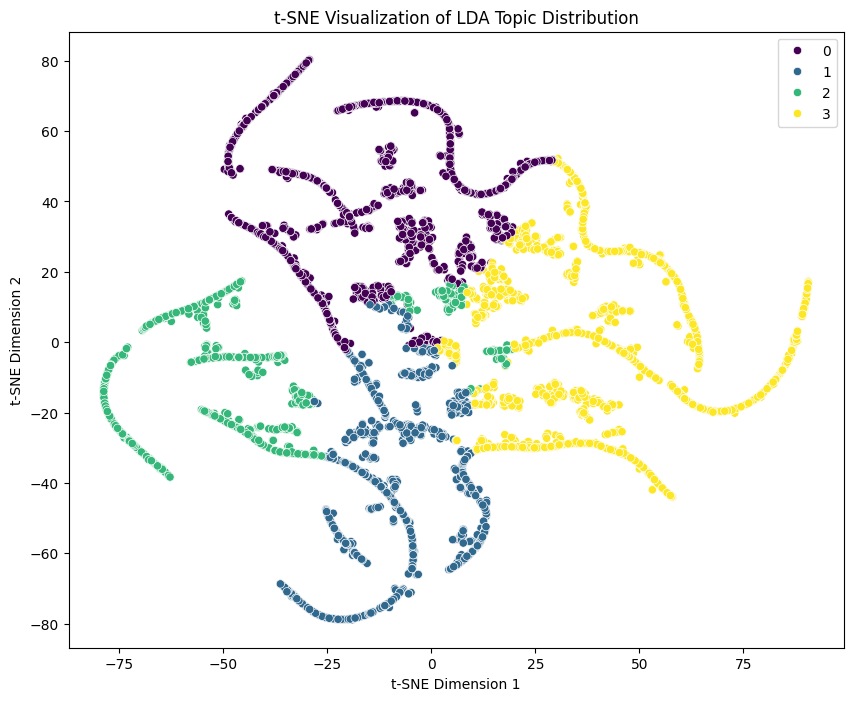

In [20]:
# Fit t-SNE model to the topic distribution
tsne_model = TSNE(n_components=2, random_state=42)
tsne_topic_distribution = tsne_model.fit_transform(topic_distribution)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_topic_distribution[:, 0], y=tsne_topic_distribution[:, 1], hue=dominant_topic, palette='viridis', legend='full')
plt.title('t-SNE Visualization of LDA Topic Distribution')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Following code chunk processes and analyzes NLP research papers over different time intervals. It:

1. Extracts the publication year from the 'publication_date' column and categorizes papers into predefined time intervals.
2. Iterates over each interval, filters papers, preprocesses abstracts, and applies LDA to identify topics.
3. Stores and prints the top words for each topic within each time interval, offering insights into the evolution of NLP research.

I thought it would be interesting to see if the topics changes over time.

In [21]:
# Extract year from the 'publication_date' column
nlp_papers_df['year'] = nlp_papers_df['publication_date'].dt.year

# Define the time intervals
time_intervals = [(1994, 2000)] + [(start, start + 4) for start in range(2001, 2016, 5)] + [(2016, 2021)]

# Create a new column 'time_interval' to categorize each paper into its respective time interval
nlp_papers_df['time_interval'] = pd.cut(nlp_papers_df['year'], bins=[interval[0] - 1 for interval in time_intervals] + [2022], labels=[f'{interval[0]}-{interval[1]}' for interval in time_intervals], right=False)

# Initialize an empty dictionary to store results for each time interval
results_by_interval = {}

# Iterate over each time interval
for interval in time_intervals:
    start_year, end_year = interval

    # Filter the DataFrame for the current time interval
    interval_df = nlp_papers_df[(nlp_papers_df['year'] >= start_year) & (nlp_papers_df['year'] <= end_year)]

    # Clean and preprocess abstracts for the current time interval
    cleaned_abstracts_interval = []
    for abstract in interval_df['abstract']:
        tokens = word_tokenize(abstract.lower())
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]
        filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]
        cleaned_abstracts_interval.append(' '.join(filtered_tokens))

    # Create Bag of Words representation for the current time interval
    X_interval = vectorizer.transform(cleaned_abstracts_interval)[:, selected_indices]

    # Fit LDA model for the current time interval
    lda_interval = LatentDirichletAllocation(n_components=elbow_point, random_state=20)
    lda_interval.fit(X_interval)

    # Get top words for each topic in the current time interval
    top_words_by_topic = []
    for topic_id, topic in enumerate(lda_interval.components_):
        top_word_indices = topic.argsort()[:-11:-1]
        top_words = feature_names[top_word_indices]
        top_words_by_topic.append(top_words)

    # Store results in the dictionary
    results_by_interval[f'{start_year}-{end_year}'] = top_words_by_topic

# Display the results
for interval, top_words_by_topic in results_by_interval.items():
    print(f"\nTime Interval: {interval}")
    for topic_id, top_words in enumerate(top_words_by_topic):
        print(f"Topic {topic_id + 1}: {', '.join(top_words)}\n{'-'*50}")


Time Interval: 1994-2000
Topic 1: language, learning, model, word, method, natural, processing, paper, system, approach
--------------------------------------------------
Topic 2: model, language, system, approach, processing, information, used, present, algorithm, application
--------------------------------------------------
Topic 3: language, system, speech, paper, research, recognition, model, natural, rate, information
--------------------------------------------------
Topic 4: language, word, paper, ha, problem, nlp, recognition, speech, algorithm, best
--------------------------------------------------

Time Interval: 2001-2005
Topic 1: method, model, computational, item, memory, comparison, ha, nlp, number, base
--------------------------------------------------
Topic 2: recognition, model, speech, method, language, system, information, lecture, transcription, show
--------------------------------------------------
Topic 3: transcript, paper, course, text, key, video, citation

In this following code chunk, I'll visualize NLP papers over the years. The code provides counts of papers for every year and plots it.

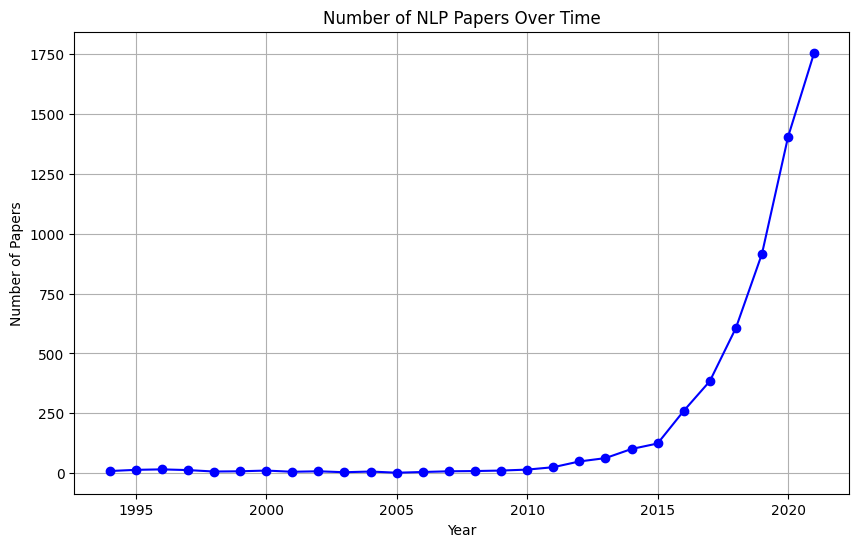

In [22]:
# Group the DataFrame by year and count the number of papers in each year
papers_per_year = nlp_papers_df['year'].value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(papers_per_year.index, papers_per_year.values, marker='o', linestyle='-', color='b')
plt.title('Number of NLP Papers Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.grid(True)
plt.show()

Following code chunk applies K-means clustering to a set of text data and determines the optimal number of clusters using the Elbow Method. This code differs from LDA in that it uses K-means clustering to group text data into clusters based on similarity, whereas LDA is a probabilistic model for topic modeling. The Elbow Method helps determine the optimal number of clusters, and the code refits the K-means model with the identified optimal clusters.

fitting k = 3
fitting k = 4
fitting k = 5
fitting k = 6
fitting k = 7
fitting k = 8
fitting k = 9
fitting k = 10
fitting k = 11
fitting k = 12
fitting k = 13
fitting k = 14
fitting k = 15
fitting k = 16
fitting k = 17
fitting k = 18
fitting k = 19
fitting k = 20


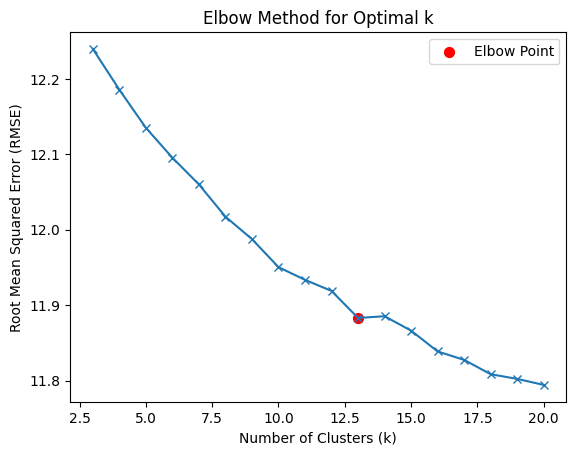

Optimal Number of Clusters (Elbow Point): 13


KMeans(n_clusters=13, n_init=10, random_state=42)

In [24]:
# Apply K-means clustering
# Initialize a list to store the Root Mean Squared Error (RMSE) values
rmse_values = []

# Iterate over different numbers of clusters
for k in range(3, 21):  # Clusters from 3 to 20
    print(f'fitting k = {k}')
    num_clusters = k

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init = 10)
    kmeans.fit(X_filtered)

    # Get cluster assignments for each paragraph
    cluster_assignments = kmeans.labels_

    # Compute distances from each point to its centroid
    distances = kmeans.transform(X_filtered)

    # Calculate the mean squared error (MSE)
    mse = np.mean(np.min(distances, axis=1)**2)

    # Calculate the RMSE
    rmse = np.sqrt(mse)

    # Append the RMSE value to the list
    rmse_values.append(rmse)

# Identify the elbow point
diffs = np.diff(rmse_values)

if len(diffs) > 0 and any(diffs > 0):
    elbow_point = np.where(diffs > 0)[0][0] + 3  # Add 3 because we started from k=3
else:
    # Set a default number of clusters or choose an alternative method
    elbow_point = 3  # You can set this to any default value or use a different approach

# Plot the RMSE values against the number of clusters
plt.plot(range(3, 21), rmse_values, marker='x')  # Extend the range to include up to 10 clusters
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')

# Mark the elbow point on the plot
if len(diffs) > 0 and any(diffs > 0):
    plt.scatter(elbow_point, rmse_values[elbow_point - 3], c='red', label='Elbow Point', marker='o', s=50)
    plt.legend()

plt.show()

# Print the identified optimal number of clusters
print(f"Optimal Number of Clusters (Elbow Point): {elbow_point}")

# Refit with optimal clusters
kmeans = KMeans(n_clusters=elbow_point, random_state=42, n_init=10)
kmeans.fit(X_filtered)

In the code above, we figured out that the optimal number of clusters is 13.

Following code chunk analyzes the top word frequencies for each cluster resulting from K-means clustering. It:

1. Retrieves cluster assignments for each paragraph.
2. Creates frequency dictionaries for words in each cluster.
3. Identifies common words across clusters.
4. Displays the top 10 distinctive word frequencies for each cluster, excluding common words.

In [25]:
# Get cluster assignments for each paragraph
cluster_assignments = kmeans.labels_

# Turn everything into frequency dictionaries
dicts_of_freqs = []
for cluster_id in range(elbow_point):
    cluster_indices = (cluster_assignments == cluster_id)

    # Extract the rows corresponding to the cluster from X_filtered
    cluster_X = X_filtered[cluster_indices]

    # Sum the columns to get the total frequency for each word
    word_frequencies = np.array(cluster_X.sum(axis=0)).reshape(-1)

    # Get the feature names (words) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())[selected_indices]

    # Create a dictionary of word frequencies
    word_frequency_dict = dict(zip(feature_names, word_frequencies))

    dicts_of_freqs.append(word_frequency_dict)

# Which words with freq>1 appear in all dictionaries?
common_words = set.intersection(*[
    set(word for word, freq in word_frequency_dict.items() if freq > 1)
    for word_frequency_dict in dicts_of_freqs
    ])

i = 0
print("Top 10 words for each cluster:")
for dict_i in dicts_of_freqs:
    # Sort the dictionary by values in descending order
    sorted_word_frequency = dict(sorted(dict_i.items(), key=lambda item: item[1], reverse=True))

    # Filter away common words
    filtered_word_frequency = {k: v for k, v in sorted_word_frequency.items() if k not in common_words}

    # Display only the top 10 word frequencies
    top_10_word_frequency = {k: sorted_word_frequency[k] for k in list(sorted_word_frequency)[:10]}

    print(f"Cluster {i+1}:\nTop 10 Word Frequencies: {top_10_word_frequency}\n{'-'*50}")
    i = i + 1

Top 10 words for each cluster:
Cluster 1:
Top 10 Word Frequencies: {'model': 3385, 'language': 904, 'task': 688, 'performance': 535, 'show': 500, 'training': 488, 'approach': 420, 'learning': 411, 'result': 401, 'paper': 398}
--------------------------------------------------
Cluster 2:
Top 10 Word Frequencies: {'topic': 763, 'model': 297, 'modeling': 227, 'document': 148, 'word': 112, 'approach': 101, 'text': 96, 'method': 91, 'data': 81, 'corpus': 78}
--------------------------------------------------
Cluster 3:
Top 10 Word Frequencies: {'speech': 1981, 'recognition': 1020, 'system': 936, 'asr': 837, 'model': 714, 'data': 428, 'performance': 405, 'automatic': 376, 'training': 358, 'speaker': 338}
--------------------------------------------------
Cluster 4:
Top 10 Word Frequencies: {'method': 1339, 'model': 453, 'language': 372, 'task': 323, 'learning': 321, 'approach': 257, 'natural': 249, 'result': 241, 'paper': 226, 'nlp': 224}
--------------------------------------------------
Cl

Following code chunk performs t-SNE (t-distributed Stochastic Neighbor Embedding) on the word frequencies obtained from K-means clustering. It visualizes the clusters in a scatter plot, where each point represents a paragraph, and the points are color-coded based on their assigned cluster. The difference between this t-SNE and the one from the LDA is, that this visualizes from X_filtered, and the LDA visualized from topic_distribution.

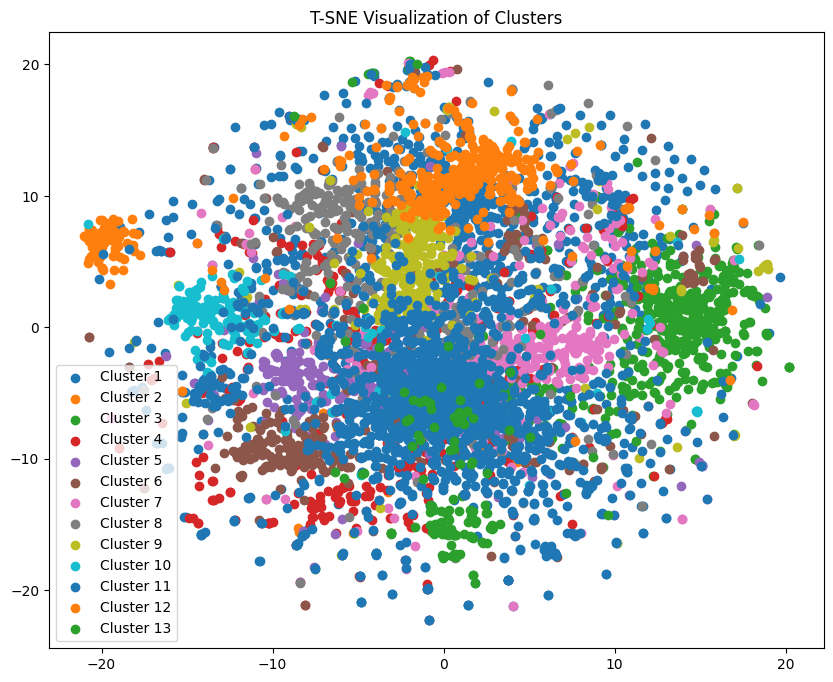

In [26]:
# Fit T-SNE to the cluster assignments
tsne = TSNE(n_components=2, random_state=42, init='random')  # Specify init='random'
tsne_results = tsne.fit_transform(X_filtered.toarray())  # Convert sparse matrix to dense array

# Create a scatter plot of the T-SNE results, color-coded by cluster
plt.figure(figsize=(10, 8))
for i in range(elbow_point):
    cluster_indices = (cluster_assignments == i)
    plt.scatter(tsne_results[cluster_indices, 0], tsne_results[cluster_indices, 1], label=f'Cluster {i+1}')

plt.title('T-SNE Visualization of Clusters')
plt.legend()
plt.show()

As we see, the visualization above is way more messy than the LDA. That's because I'd already assigned topic distribution for the LDA before the t-SNE. Though there is some system in the clustering here but not much.

The following code employs the Sentence Transformer library to encode a list of abstracts into dense vector representations using the 'all-MiniLM-L6-v2' pre-trained model. The resulting vectors, stored in X_embeddings, can be utilized for various natural language processing tasks.

In [27]:
# Extract abstracts from the DataFrame
abstracts = nlp_papers_df['abstract'].tolist()

In [28]:
# Initialize a Sentence Transformer model (all-MiniLM-L6-v2)
sent_encoder = SentenceTransformer('all-MiniLM-L6-v2')

# Encode abstracts into dense vector representations
X_embeddings = sent_encoder.encode(abstracts, show_progress_bar=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/183 [00:00<?, ?it/s]

In this code chunk, dimensionality reduction is conducted on dense vector representations (X_embeddings) obtained from abstracts using t-distributed t-SNE. The resulting lower-dimensional representations are stored in X_tsne with three components, facilitating visualizations of the high-dimensional data.

In [30]:
# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

In the following code chunk, I'll apply K-Means clustering to lower-dimensional representations (X_tsne) obtained through t-SNE. The clustering utilizes cosine distance as the similarity metric. The code iterates over various cluster counts (from 5 to 40), calculates the Root Mean Squared Error (RMSE) for each clustering, and identifies the optimal number of clusters using the Elbow Method. The resulting plot illustrates the RMSE values against the number of clusters, with a marked elbow point indicating the suggested optimal cluster count. The identified optimal number of clusters is then printed for further analysis.

fitting k = 5
fitting k = 6
fitting k = 7
fitting k = 8
fitting k = 9
fitting k = 10
fitting k = 11
fitting k = 12
fitting k = 13
fitting k = 14
fitting k = 15
fitting k = 16
fitting k = 17
fitting k = 18
fitting k = 19
fitting k = 20
fitting k = 21
fitting k = 22
fitting k = 23
fitting k = 24
fitting k = 25
fitting k = 26
fitting k = 27
fitting k = 28
fitting k = 29
fitting k = 30
fitting k = 31
fitting k = 32
fitting k = 33
fitting k = 34
fitting k = 35
fitting k = 36
fitting k = 37
fitting k = 38
fitting k = 39
fitting k = 40


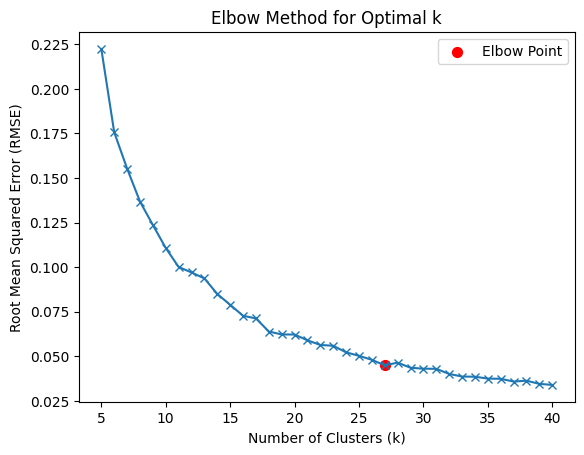

Optimal Number of Clusters (Elbow Point): 27


In [31]:
# Apply K-Means clustering with cosine distance
# Initialize a list to store the RMSE values
rmse_values = []

# Iterate over different numbers of clusters
for k in range(5, 41):  # I'll try clusters from 5-40
    print(f'fitting k = {k}')
    num_clusters = k

    # Apply K-Means clustering with cosine distance
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init = 10)
    kmeans.fit(X_tsne)

    # Get cluster assignments for each paragraph
    cluster_assignments = kmeans.labels_

    # Compute distances from each point to its centroid
    distances = cosine_distances(X_tsne, kmeans.cluster_centers_)

    # Calculate the mean squared error (MSE)
    mse = np.mean(np.min(distances, axis=1)**2)

    # Calculate the RMSE
    rmse = np.sqrt(mse)

    # Append the RMSE value to the list
    rmse_values.append(rmse)

# Identify the elbow point
diffs = np.diff(rmse_values)

if len(diffs) > 0 and any(diffs > 0):
    elbow_point = np.where(diffs > 0)[0][0] + 5  # Add 5 because we started from k=5
else:
    # Set a default number of clusters or choose an alternative method
    elbow_point = 5  # You can set this to any default value or use a different approach

# Plot the RMSE values against the number of clusters
plt.plot(range(5, 41), rmse_values, marker='x')  # Adjust the range to match the loop starting from k=5
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')

# Mark the elbow point on the plot
if len(diffs) > 0 and any(diffs > 0):
    plt.scatter(elbow_point, rmse_values[elbow_point - 5], c='red', label='Elbow Point', marker='o', s=50)
    plt.legend()

plt.show()

# Print the identified optimal number of clusters
print(f"Optimal Number of Clusters (Elbow Point): {elbow_point}")

In the following code chunk, I'll refit with the optimal clusters obtained from the code above, which is 27. Also, I'll find the centran sentences from each cluster. Compared to LDA and K-means clustering from ealier, this method gains information from sentences instead of words.

In [34]:
# Refit with optimal clusters
elbow_point = 27
kmeans = KMeans(n_clusters=elbow_point, random_state=42, n_init = 10)
kmeans.fit(X_tsne)

# Find central sentence
central_sentences = []

for cluster_id in range(elbow_point):  # Use the optimal number of clusters

    # Extract the rows corresponding to the cluster from X_filtered
    cluster_indices = (cluster_assignments == cluster_id)
    cluster_X = np.array(abstracts)[cluster_indices]
    X_tsne_cluster = X_tsne[cluster_indices]

    if len(cluster_X) > 0:
        # Find the paragraph index of the centroid (closest to the centroid)
        centroid_index = np.argsort(np.sum((X_tsne_cluster - kmeans.cluster_centers_[cluster_id])**2, axis=1))[:3]

        # Get the entire paragraph corresponding to the centroid
        central_sentence = cluster_X[centroid_index]

        central_sentences.append(central_sentence)


At last, in this code, I'll visualize the results in a t-SNE reduced space clustering. Furthermore, I'll extract the central sentences for each cluster.

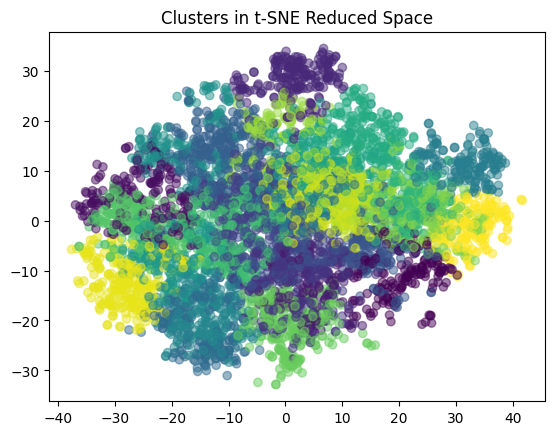


Central Sentences:
Cluster 1: ['  k-fold cross validation (cv) is a popular method for estimating the true\nperformance of machine learning models, allowing model selection and parameter\ntuning. however, the very process of cv requires random partitioning of the\ndata and so our performance estimates are in fact stochastic, with variability\nthat can be substantial for natural language processing tasks. we demonstrate\nthat these unstable estimates cannot be relied upon for effective parameter\ntuning. the resulting tuned parameters are highly sensitive to how our data is\npartitioned, meaning that we often select sub-optimal parameter choices and\nhave serious reproducibility issues.\n  instead, we propose to use the less variable j-k-fold cv, in which j\nindependent k-fold cross validations are used to assess performance. our main\ncontributions are extending j-k-fold cv from performance estimation to\nparameter tuning and investigating how to choose j and k. we argue that\nvariabi

In [35]:
# Get cluster assignments for each paragraph
cluster_assignments = kmeans.labels_

# Visualize clusters in 2D
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.5)

plt.title('Clusters in t-SNE Reduced Space')
plt.show()

# Print central sentences
print("\nCentral Sentences:")
for i, sentence in enumerate(central_sentences):
    print(f"Cluster {i + 1}: {sentence}\n{'-' * 50}")